In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


In [3]:
# Load train data (TODO: try out PCA)
train = None
labels = None
for i in range(1,6):
    batch = unpickle("cifar-10-batches-py/data_batch_{}".format(i))
    if train is None:
        train = batch[b'data'].astype(np.float32)/255.0
        labels = batch[b'labels']
    else:
        train = np.concatenate((train, \
            batch[b'data'].astype(np.float32)/255.0), axis = 0)
        labels.extend(batch[b'labels'])
        
train_data = train
train_labels = np.array(labels).reshape((-1,1))

# Load test data
test = unpickle("cifar-10-batches-py/test_batch")
test_data = test[b'data'].astype(np.float32)/255.0
test_labels = np.array(test[b'labels']).reshape((-1,1))

label_names = unpickle("cifar-10-batches-py/batches.meta")

In [4]:
for key in label_names:
    print(key, label_names[key])

b'num_cases_per_batch' 10000
b'label_names' [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']
b'num_vis' 3072


In [5]:
num_components = 2
X_m = train_data - np.mean(train_data, 0).reshape(1,3072)
U,s,VT = np.linalg.svd(X_m,full_matrices=False)


In [6]:
components = VT[0:2,:].T
coords = X_m @ components

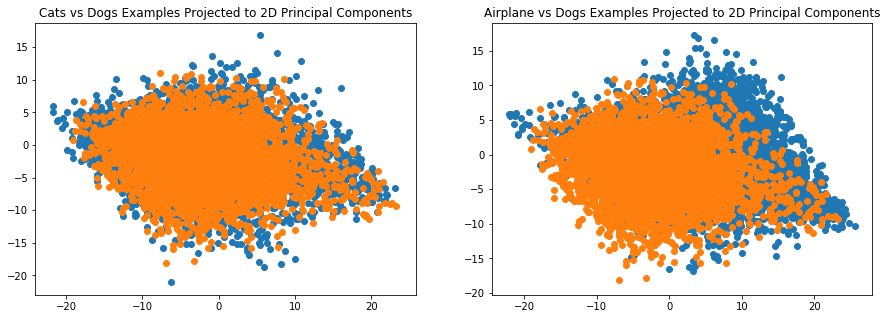

In [7]:
airplane_x = []
airplane_y = []
cats_x = []
cats_y = []
dogs_x = []
dogs_y = []
for i in range(len(X_m)):
    if train_labels[i] == 0:
        airplane_x.append(coords[i][0])
        airplane_y.append(coords[i][1])
    elif train_labels[i] == 3:
        cats_x.append(coords[i][0])
        cats_y.append(coords[i][1])
    elif train_labels[i] == 5:
        dogs_x.append(coords[i][0])
        dogs_y.append(coords[i][1])

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(cats_x, cats_y)
ax[0].scatter(dogs_x, dogs_y)
ax[0].set_title("Cats vs Dogs Examples Projected to 2D Principal Components")
ax[1].scatter(airplane_x, airplane_y)
ax[1].scatter(dogs_x, dogs_y)
ax[1].set_title("Airplane vs Dogs Examples Projected to 2D Principal Components")
plt.show()

In [8]:
bucketized_data = []
for i in range(10):
    bucket_i_labels = np.array([1 if train_labels[k] == i else 0 for k in range(len(train_data)) ])
    bucketized_data.append(np.array(bucket_i_labels))
    
# Make sure I bucketized data correctly into separate classes
print(bucketized_data)

[array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 1, 1]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([1, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 1, 1, ..., 1, 0, 0])]


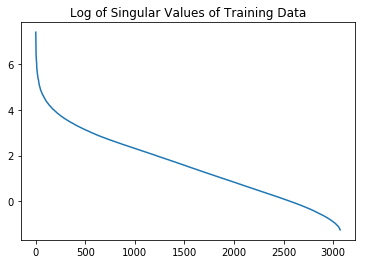

In [9]:
plt.plot(np.arange(len(s)), np.log(s))
plt.title("Log of Singular Values of Training Data")
plt.show()

In [12]:
from sklearn.svm import SVC
import pickle
classnames = [x.decode("utf-8") for x in label_names[b'label_names']]
components = VT[0:200,:].T
coords = X_m @ components

In [17]:
components = VT[0:200,:].T
coords = X_m @ components
classifiers_with_bagging = []
for i in range(10):
    positive = np.array([coords[k]  for k in range(len(train_data)) if train_labels[k] == i])
    negative = np.array([coords[k]  for k in range(len(train_data)) if train_labels[k] != i])
    negative_sample = negative[np.random.choice(np.arange(len(negative)), len(positive))] # get a bag
    classifier_labels = np.array([1] * len(positive) + [0] * len(positive))
    svm_train_data = np.concatenate((positive, negative_sample), axis=0)
    svm = SVC(gamma='auto')
    svm.fit(svm_train_data, classifier_labels)
    with open("{}_classifier_weights_with_bagging.pkl".format(classnames[i]), "wb") as f:
        pickle.dump(svm, f)
    classifiers.append(svm)

In [ ]:
# Based on singular values, first 200 or so seem important
# Don't run this cell more than once. It takes a very long time
components = VT[0:200,:].T
coords = X_m @ components
classifiers = []
for i in range(10):
    svm = SVC(gamma='auto')
    svm.fit(coords, bucketized_data[i])
    with open("{}_classifier_weights.pkl".format(classnames[i]), "wb") as f:
        pickle.dump(svm, f)
    classifiers.append(svm)


In [19]:
classifiers = []
for i in range(10):
    with open("{}_classifier_weights.pkl".format(classnames[i]), "rb") as f:
        svm = pickle.load(f)
        classifiers.append(svm)
        
def predict_example(image):
    mean_subtracted = image - np.mean(train_data, 0).reshape(1,3072)
    projection = mean_subtracted @ components
    predictions = []
    for classifier in classifiers:
        predictions.append(classifier.decision_function(projection)[0])
    return np.argmax(predictions)

    
correct = 0
total = 0
for i in range(len(test_data)):
    prediction = predict_example(test_data[i])
    if prediction == test_labels[i]:
        correct += 1
    total += 1
correct/total

0.5488